In [20]:
import cv2
import tensorflow as tf
from glob import glob
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [3]:
# PATH = "drive/MyDrive/Breast-Ultrasound-Images/Dataset_BUSI_with_GT"
PATH = "../input/breast-cancer/Dataset."
tpu_ = False

In [4]:
if tpu_:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # instantiate a distribution strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [5]:
def collect_data(name):
    """
    For a classname create the two path list of images and masks
    """
    all_images = sorted(
        glob(os.path.join(PATH, name + "/*).png")),
        key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
    )
    all_masks = sorted(
        glob(os.path.join(PATH, name + "/*mask*")),
        key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
    )
    # print(all_masks[:4])
    return all_images, all_masks


def group_maks(masks):
    """
    Read the mask file and combine the masks images when their are several masks for a
    single image ( after
    """
    new_masks = []
    retard = 0
    for i in range(len(masks)):
        m = re.search(r"mask_[0-9]", masks[i]) # we are looking for masks that correspond to the same inputs
        if m:
            new_masks[i - (retard + 1)] += cv2.resize(
                cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE), (256, 256)
            )
            retard += 1
        else:
            new_masks.append(
                cv2.resize(
                    cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE), (256, 256)
                )  # resize needed because the image need to have the same size
            )

    return new_masks


def load_dataset():
    """
    Combine the previous function and differents class label and apply train_test_split on it

    Retuns :
        - X_train() : the matrix of training images
        - y_train() : the matrix of training masks
        - X_test() : the matrix of testing images
        - y_test() : the matrix of testing masks
    """
    all_benign_images, all_benign_masks = collect_data("benign")

    # Here all = tf.constant(all_benign_masks) works
    all_benign_masks = group_maks(all_benign_masks)
    # Here it doesnt
    all_malignant_images, all_malignant_masks = collect_data("malignant")
    all_malignant_masks = group_maks(all_malignant_masks)

    all_images = all_benign_images + all_malignant_images
    all_masks = all_benign_masks + all_malignant_masks

    X_train, X_test = train_test_split(
        all_images,
        test_size=0.2,
        random_state=1,
        # shuffle=True,
    )
    y_train, y_test = train_test_split(
        all_masks,
        test_size=0.2,
        random_state=1,
        # shuffle=True,
    )
    return (X_train, y_train), (X_test, y_test)


def show_some_images(images, masks):
    """
    Show a numbers of images and it's associated masks
    """

    random_number = randint(0, len(images) - 6)
    # random_number = 4  # Used to check on malignant
    plt.figure(figsize=(20, 10))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[random_number + i + 1], "gray")
        plt.axis("off")
        plt.title("Real Image")
    for i in range(5):
        plt.subplot(2, 5, i + 6)
        plt.imshow(masks[random_number + i + 1], "gray")
        plt.title("Mask Image")
        plt.axis("off")
    plt.show()


def process_image(image, HEIGHT=256, WIDTH=256):
    image = image.decode("utf-8")
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (HEIGHT, WIDTH))
    image = image / 255.0

    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=-1)
    return image


def process_mask(mask):
    """
    Mask proccessing function
    """
    mask = mask.astype(np.float32)
    mask = mask / 255
    mask = np.round(mask) # Rounds between 0 and 1 each pixels
    mask = np.expand_dims(mask, axis=-1)  # need shape to be (256,256,1)
    return mask


def preprocess(x, y):
    def f(x, y):
        image = process_image(x)
        mask = process_mask(y)
        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    image.set_shape([256, 256, 1])
    mask.set_shape([256, 256, 1])
    return image, mask


def tf_dataset(x, y, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(preprocess)
    ds = ds.batch(batch_size)
    return ds


def load(batch_size=16):
    (X_train, y_train), (X_test, y_test) = load_dataset()
    """ X_train = X_train[:64]
    y_train = y_train[:64]
    X_test = X_test[:64]
    y_test = y_test[:64] """
    train_ds = tf_dataset(X_train, y_train, batch_size=batch_size)
    test_ds = tf_dataset(X_test, y_test, batch_size=batch_size)
    return train_ds, test_ds

2022-10-28 09:09:40.509267: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-28 09:09:40.512984: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-28 09:09:40.580210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 09:09:40.580990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-10-28 09:09:40.581070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-28 09:09:40.611769: I tensorflow/stream_executor/platform/def

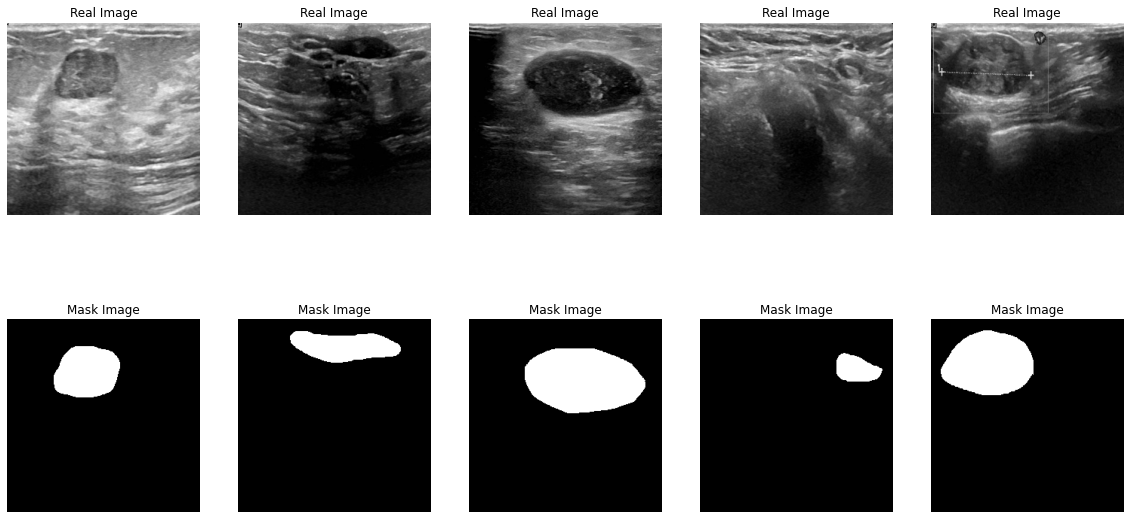

In [6]:
(X_train, y_train), (X_test, y_test) = load_dataset()
train_ds = tf_dataset(X_train, y_train, batch_size=16)
test_ds = tf_dataset(X_test, y_test, batch_size=16)
for x, y in train_ds.take(1):show_some_images(x, y)

In [7]:
def block_conv_down(x, dims):
    x = tf.keras.layers.Conv2D(
        dims,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(
        dims,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    p = tf.keras.layers.Dropout(0.2)(p)
    return x, p


def bottleneck(x, dims):
    x = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def block_conv_up(x, p, dims):
    p = tf.keras.layers.UpSampling2D(2)(p)
    u = tf.keras.layers.Concatenate(axis=-1)([p, x])

    u = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(u)
    u = tf.keras.layers.BatchNormalization()(u)
    u = tf.keras.layers.Activation("relu")(u)
    u = tf.keras.layers.Dropout(0.1)(u)

    u = tf.keras.layers.Conv2D(
        dims,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(u)
    u = tf.keras.layers.BatchNormalization()(u)
    u = tf.keras.layers.Activation("relu")(u)
    u = tf.keras.layers.Dropout(0.1)(u)

    return u


def UNET(input_shape):
    input = tf.keras.layers.Input(shape=input_shape)
    x1, p1 = block_conv_down(input, 64)
    # print(f" x1 shape : {x1.shape}")
    x2, p2 = block_conv_down(p1, 128)
    # print(f" x2 shape : {x2.shape}")
    x3, p3 = block_conv_down(p2, 256)
    # print(f" x3 shape : {x3.shape}")
    x4, p4 = block_conv_down(p3, 512)
    # print(f" x4 shape : {x4.shape}")

    p5 = bottleneck(p4, 1024)
    # print(f" p5 shape : {p5.shape}")
    p6 = block_conv_up(x4, p5, 512)
    # print(f" p6 shape : {p6.shape}")
    p7 = block_conv_up(x3, p6, 256)
    # print(f" p7 shape : {p7.shape}")
    p8 = block_conv_up(x2, p7, 128)
    # print(f" p8 shape : {p8.shape}")
    p9 = block_conv_up(x1, p8, 64)

    # print(f" p9 shape : {p9.shape}")

    output = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(p9)
    # output = tf.keras.layers.Conv2D(2,(1,1), activation = "softmax")
    model = tf.keras.Model(inputs=input, outputs=output)

    return model

In [24]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred) 

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss_r(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [26]:
if tpu_:
    with tpu_strategy.scope():
        model = UNET((256, 256, 1))
        
        model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
        model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=50,
            steps_per_epoch=len(train_ds),
            )
else :
    model = UNET((256, 256, 1))
    metrics = ["accuracy", jacard_coef, iou_coef, dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)]  
    loss = [jacard_coef_loss, tversky_loss, focal_tversky_loss_r, "binary_crossentropy"]
    model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),loss= loss, metrics=metrics,)
    
    model.fit( train_ds, validation_data=test_ds, epochs=50, steps_per_epoch=len(train_ds),)

Epoch 1/50
33/33 [==============================] - 20s 531ms/step - loss: -0.1315 - accuracy: 0.6554 - jacard_coef: 0.1315 - iou_coef: 0.1214 - dice_coef: 0.1956 - mean_io_u_5: 0.4750 - val_loss: -0.0976 - val_accuracy: 0.0976 - val_jacard_coef: 0.1040 - val_iou_coef: 0.1040 - val_dice_coef: 0.1747 - val_mean_io_u_5: 0.0488
Epoch 2/50
33/33 [==============================] - 17s 513ms/step - loss: -0.2459 - accuracy: 0.8585 - jacard_coef: 0.2459 - iou_coef: 0.2388 - dice_coef: 0.3511 - mean_io_u_5: 0.5258 - val_loss: -0.0976 - val_accuracy: 0.0976 - val_jacard_coef: 0.1040 - val_iou_coef: 0.1040 - val_dice_coef: 0.1747 - val_mean_io_u_5: 0.0488
Epoch 3/50
33/33 [==============================] - 17s 514ms/step - loss: -0.2776 - accuracy: 0.8901 - jacard_coef: 0.2777 - iou_coef: 0.2677 - dice_coef: 0.3762 - mean_io_u_5: 0.5491 - val_loss: -0.1013 - val_accuracy: 0.1346 - val_jacard_coef: 0.1079 - val_iou_coef: 0.1079 - val_dice_coef: 0.1802 - val_mean_io_u_5: 0.0731
Epoch 4/50
33/33 [=

In [27]:
model.save("UNETBreast.h5")